## Entrenamiento de redes neuronales Conv y LSTM

In [1]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, Dropout, Flatten
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, Layer, LSTM, SpatialDropout1D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import Constant
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from time import time
from tensorflow.python.client import device_lib
from time import time

import matplotlib.pyplot as plt
import tensorflow.keras.layers as layers
import tensorflow.keras.backend as tensorflow_backend
import tensorflow as tf
import numpy as np
import pandas as pd

import pprint
import os
import sys
import h5py
import pickle


### Configuración GPU

In [2]:
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True),log_device_placement=True)
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14381397115257655622
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 5152440467786162038
physical_device_desc: "device: XLA_CPU device"
]


## Rutas y constantes

In [5]:
DIR_DATASET = '../data/facturas.csv'
NOMBRE_COLUMNAS = ['Texto','Clase']
TEST_SIZE = 0.10
RANDOM_STATE = 42
NAME_TOKENIZER = "../data/tokenizer_indra.pickle"

### Lectura de dataset

In [6]:
def read_dataset(path, nombre_cols ):
    dataset = pd.read_csv(DIR_DATASET)
    id_labels = list(dataset['Id_clase'])
    X = dataset[nombre_cols]
    return dataset, id_labels, X

In [7]:
dataset, id_labels, X = read_dataset(DIR_DATASET, NOMBRE_COLUMNAS)


In [8]:
dataset.tail()

Texto       Clase  Id_clase
4348   mayr melnhof packaging ib rica s l u ctra cv ...  Intermedio         2
4349   firmenich sa rue de la berg re  meyrin   gene...  Intermedio         2
4350   firmenich sa fiscal representative rue de la ...  Intermedio         2
4351   firmenich sa fiscal representative rue de la ...  Intermedio         2
4352   firmenich sa rue de la berg re  meyrin   gene...  Intermedio         2

### Separación entrenamiento y test

In [16]:
def separar_train_test(X, id_labels, test_size, random_state):
    return train_test_split( X, id_labels, test_size=test_size, random_state=random_state)

In [17]:
X_train, X_test, y_train, y_test = separar_train_test(X, id_labels, TEST_SIZE, RANDOM_STATE)
train_l = list(X_train['Texto'])
test_l = list(X_test['Texto'])

In [18]:
train_l[0]

' albben o  domicilio social matar    granollers  clf b oficinas centrales paseo de gracia    barcelona telef     od le fax   health hygiene home o reckitt benckiser espa a s l cas sociedad unipersonal tipo n albar n fecha albar n direccion pag  on  eoos    covaldroper valencia o  ml  cl pedrapiquer polig vara d pedido por n pedido fecha pedidd entregar   sovossesg      valencia  valencia  proveedor pedido cliente     cdigo cdigo ean descripcin und alm und cons   flor elixir  sensorial l  d     flor elixir herbal l  d      flor elixir azul l  d    c palet chep   al covaldroper mercanc a s n repasar ez bultos s n contar _ desconocemos conten se veceegionor y ees totales    atm n ruta ag peso bruto kg volumen m   ld      renuncio a mi propio fuero y mb someto expresamente a los tribunales de barcelona observaciones fecha de entrega hora muelle cabecera on        producto por palet conforme recepcion '

### Carga word embeddings

In [19]:
GLOVE_EMBEDDING_PATH = '../data/glove.6B.100d.txt'

def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')

def load_embeddings(embed_dir):
    embedding_index = dict(get_coefs(*o.strip().split(" ")) for o in tqdm(open(embed_dir)))
    return embedding_index

glove = load_embeddings(GLOVE_EMBEDDING_PATH)

400000it [00:12, 32071.46it/s]


### Carga alternativa de word embeddings

In [12]:
path_emb = 'glove.840B.300d.pkl'

t = time()
with open(path_emb, 'rb') as fp:
    glove = pickle.load(fp)
print(time()-t)

FileNotFoundError: [Errno 2] No such file or directory: 'glove.840B.300d.pkl'

### Configuración de ambos modelos

In [34]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NUM_WORDS = 30000
EMBEDDING_DIM = 100
FILTERS = 128
KERNEL_SIZE = 5
ACTIVATION = 'softmax'
ACTIVATION_CONV_LAYERS = 'relu'
POOL_SIZE = 5
BATCH_SIZE = 128
EPOCHS = 15
CALLBACK = EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)
LOSS = 'categorical_crossentropy'
OPTIMIZER = 'adam'
METRICS = 'acc'
NUMBER_OF_CLASSES = 3


### Representación matemática de los textos

In [21]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(train_l)
tokenizer.fit_on_texts(test_l)
sequences_train = tokenizer.texts_to_sequences(train_l)
sequences_test = tokenizer.texts_to_sequences(test_l)
word_index = tokenizer.word_index
num_words = min(MAX_NUM_WORDS, len(word_index)) + 1

In [22]:
def save_tokenizer(path_name, tokenizer):
    with open(path_name, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
save_tokenizer(NAME_TOKENIZER, tokenizer)

In [23]:
data_train = pad_sequences(sequences_train, maxlen=MAX_SEQUENCE_LENGTH)
data_test = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)

In [24]:
labels_train = to_categorical(np.asarray(y_train))
labels_test = to_categorical(np.asarray(y_test))

In [25]:
print('Dimensiones del tensor de los datos de entrenamiento:', data_train.shape)
print('Dimensiones del tensor de los datos de prueba:', data_test.shape)
print('Dimensiones del tensor de las etiquetas de entrenamiento: ', labels_train.shape)
print('Dimensiones del tensor de las etiquetas de prueba:', labels_test.shape)

Dimensiones del tensor de los datos de entrenamiento: (3917, 1000)
Dimensiones del tensor de los datos de prueba: (436, 1000)
Dimensiones del tensor de las etiquetas de entrenamiento:  (3917, 3)
Dimensiones del tensor de las etiquetas de prueba: (436, 3)


### Creación de la capa y la matriz de  word embeddings 

In [26]:
def create_embedding_matrix(num_words, max_words, dim, word_index, glove):
    embedding_matrix = np.zeros((num_words, dim))
    for word, i in word_index.items():
        if i > max_words:
            continue
        embedding_vector = glove.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(num_words, MAX_NUM_WORDS, EMBEDDING_DIM, word_index, glove)

In [27]:
def create_embedding_layer(num_words, dim, embedding_matrix, max_sequence_length):
    embedding_layer = Embedding(input_dim=num_words,
                                output_dim=dim,
                                embeddings_initializer=Constant(embedding_matrix),
                                input_length=MAX_SEQUENCE_LENGTH, trainable=False)
    return embedding_layer

embedding_layer = create_embedding_layer(num_words, EMBEDDING_DIM, embedding_matrix, MAX_SEQUENCE_LENGTH)

### Entrenamiento modelo convolucional

In [35]:
def train_conv_model(max_sequence_length, filters, kernel_size, activation, loss, custom_optimizer, metrics,
                     activation_conv_layers, pool_size, batch_size, epochs, cb, number_of_classes):
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

    embedded_seq= embedding_layer(sequence_input)

    layer = Conv1D(filters=filters, kernel_size=kernel_size, activation=activation_conv_layers)(embedded_seq)
    layer = MaxPooling1D(pool_size=pool_size)(layer)
    layer = Conv1D(filters=filters, kernel_size=kernel_size, activation=activation_conv_layers)(layer)
    layer = GlobalMaxPooling1D()(layer)
    layer = Flatten()(layer)
    layer = Dense(units=filters, activation=activation_conv_layers)(layer)
    preds = Dense(units=number_of_classes, activation=activation)(layer)

    model = Model(sequence_input, preds)
    model.compile(loss=loss, optimizer=custom_optimizer, metrics=[metrics])

    historia=model.fit(data_train, labels_train, batch_size=batch_size, epochs=epochs, validation_data=(data_test, labels_test),
                       callbacks=[cb])
    return model, historia

In [36]:
model, history = train_conv_model(max_sequence_length= MAX_SEQUENCE_LENGTH, filters=FILTERS,
                                         kernel_size=KERNEL_SIZE, activation=ACTIVATION,
                                         loss=LOSS, custom_optimizer=OPTIMIZER, metrics=METRICS,
                                         activation_conv_layers=ACTIVATION_CONV_LAYERS,
                                         pool_size=POOL_SIZE, batch_size=BATCH_SIZE,
                                         epochs=EPOCHS, cb=CALLBACK,
                                         number_of_classes=NUMBER_OF_CLASSES)

Train on 3917 samples, validate on 436 samples
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/15
3917/3917 [==============================] - 35s 9ms/sample - loss: 1.0638 - acc: 0.4761 - val_loss: 0.9303 - val_acc: 0.5872
Epoch 2/15
3917/3917 [==============================] - 32s 8ms/sample - loss: 0.8043 - acc: 0.6533 - val_loss: 0.7193 - val_acc: 0.7179
Epoch 3/15
3917/3917 [==============================] - 32s 8ms/sample - loss: 0.6058 - acc: 0.7713 - val_loss: 0.6127 - val_acc: 0.7615
Epoch 4/15
3917/3917 [==============================] - 34s 9ms/sample - loss: 0.4586 - acc: 0.8369 - val_loss: 0.5502 - val_acc: 0.7890
Epoch 5/15
3917/3917 [==============================] - 32s 8ms/sample - loss: 0.3578 - acc: 0.8787 - val_loss: 0.6117 - val_acc: 0.7775
Epoch 6/15
3917/3917 [==============================] - 32s 8ms/sample - loss: 0.2688 - acc: 0.9124 - val_loss: 0.5163 - val_acc: 0.8096
Epoch

### Entrenamiento modelo LSTM

In [2]:
def train_lstm_model(max_sequence_length, num_words, dim, spatial_dropout, units_lstm,
                     dropout_lstm, rr_dropout_lstm, loss, activation_dense, optimizer, metrics,
                     batch_size, epochs, cb, n_clases):
    model_lstm = Sequential()
    model_lstm.add(Embedding(num_words, dim, input_length=MAX_SEQUENCE_LENGTH))
    model_lstm.add(SpatialDropout1D(spatial_dropout))
    model_lstm.add(LSTM(units=units_lstm, dropout=dropout_lstm, recurrent_dropout=rr_dropout_lstm))
    model_lstm.add(Dense(n_clases, activation=activation_dense))
    model_lstm.compile(loss=loss, optimizer=optimizer, metrics=[metrics])
    historia = model_lstm.fit(data_train, labels_train, batch_size=batch_size, epochs=epochs, validation_data=(data_test, labels_test),
                       callbacks=[cb])
    
    return  model_lstm, historia

   

In [3]:
 model_lstm, history = train_lstm_model(max_sequence_length= MAX_SEQUENCE_LENGTH, num_words=num_words,
                                         dim=100, spatial_dropout=0.2, units_lstm=100, dropout_lstm=0.2,
                                         rr_dropout_lstm=0.2, loss=LOSS, activation_dense = "softmax", 
                                         optimizer=OPTIMIZER, metrics=METRICS, batch_size = 100,
                                         epochs=EPOCHS_LSTM, cb=CALLBACK, n_clases=NUMBER_OF_CLASSES
                                         )

NameError: name 'MAX_SEQUENCE_LENGTH' is not defined

### Acc vs Loss

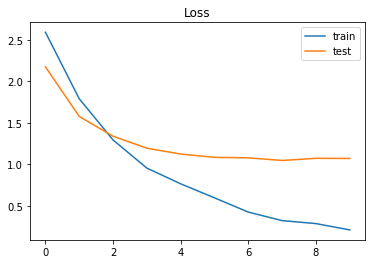

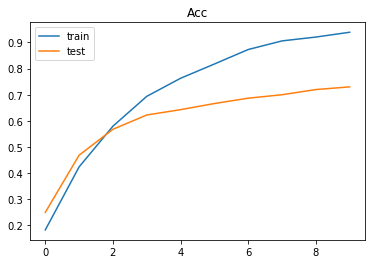

In [45]:
def plot_history(titulo, historia, val_1, val_2):
    plt.title(titulo)
    plt.plot(historia.history[val_1], label='train')
    plt.plot(historia.history[val_2], label='test')
    plt.legend()
    plt.show()

plot_history('Loss', history, 'loss','val_loss')
plot_history('Acc', history, 'acc', 'val_acc')

### Evaluar un modelo

In [ ]:
def evaluate_model(model, data_test, labels_test):
    accr = model.evaluate(data_test,labels_test)
    print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))
    
evaluate_model(model, data_test, labels_test)

### Guardar un modelo

In [38]:
def save_model(model, name):
    model.save(name + '.h5')
    
save_model(model,"conv_indra_v1")

### Predicciones sobre un modelo

In [46]:
def to_sequences(data_test, tokenizer):
    sequences_test = tokenizer.texts_to_sequences(data_test)
    data_test_seq = pad_sequences(sequences_test, maxlen=MAX_SEQUENCE_LENGTH)
    return data_test_seq

def model_predict(y_seq, data_test_seq, model):
    seq_list = []
    predictions = []
    
    for text_seq in range(0,len(y_seq)):
        seq_list.append(data_test_seq[text_seq].reshape((1,MAX_SEQUENCE_LENGTH)))

    for text_pred in seq_list:   
        predictions.append(model.predict(text_pred).argmax())
        
    return predictions

t = time()
predictions = model_predict(y_test, data_test, model_lstm)
print(time()-t)



535.1869626045227


In [25]:
target_names_indra = ["Final", "Inicial", "Intermedio"]

In [48]:
target_names_news = ["comp.graphics",
"comp.os.ms-windows.misc",
"comp.sys.ibm.pc.hardware",
"comp.sys.mac.hardware",
"comp.windows.x",
"misc.forsale",
"rec.autos",
"rec.motorcycles",
"rec.sport.baseball",
"rec.sport.hockey",
"sci.crypt",
"sci.electronics",
"sci.med",
"sci.space",
"soc.religion.christian",
"talk.politics.guns",
"talk.politics.mideast"]
y_test

[11,
 1,
 0,
 2,
 15,
 9,
 12,
 10,
 10,
 10,
 3,
 3,
 2,
 0,
 8,
 15,
 6,
 0,
 16,
 10,
 7,
 7,
 14,
 0,
 2,
 11,
 8,
 2,
 13,
 14,
 2,
 15,
 10,
 8,
 6,
 5,
 15,
 3,
 16,
 6,
 2,
 8,
 1,
 5,
 7,
 8,
 9,
 6,
 7,
 9,
 8,
 13,
 5,
 6,
 12,
 7,
 13,
 1,
 7,
 3,
 10,
 10,
 3,
 16,
 2,
 15,
 0,
 7,
 3,
 6,
 5,
 5,
 0,
 11,
 5,
 16,
 0,
 10,
 1,
 13,
 15,
 1,
 3,
 15,
 2,
 10,
 14,
 9,
 13,
 3,
 16,
 12,
 15,
 2,
 5,
 9,
 9,
 7,
 4,
 11,
 14,
 12,
 0,
 0,
 1,
 10,
 6,
 2,
 3,
 6,
 7,
 1,
 7,
 5,
 3,
 7,
 6,
 7,
 8,
 14,
 13,
 1,
 9,
 9,
 1,
 1,
 2,
 13,
 1,
 6,
 14,
 15,
 5,
 12,
 13,
 8,
 8,
 0,
 5,
 12,
 3,
 3,
 0,
 9,
 15,
 5,
 6,
 2,
 14,
 14,
 3,
 12,
 9,
 8,
 16,
 10,
 0,
 1,
 0,
 5,
 16,
 2,
 2,
 6,
 5,
 6,
 6,
 16,
 5,
 0,
 11,
 4,
 10,
 0,
 4,
 8,
 3,
 16,
 13,
 9,
 12,
 13,
 10,
 16,
 8,
 7,
 5,
 1,
 3,
 3,
 10,
 3,
 11,
 14,
 10,
 4,
 7,
 0,
 15,
 11,
 9,
 14,
 7,
 0,
 9,
 10,
 2,
 1,
 12,
 7,
 5,
 16,
 2,
 2,
 5,
 14,
 2,
 13,
 16,
 16,
 16,
 7,
 10,
 4,
 12,
 2,
 7,
 8,
 9,
 11

### Crear informe de predicciones

In [49]:
def check_class_report(y_real, y_preds, classes_names):
    print(classification_report(y_real, y_preds, target_names=classes_names))
    
check_class_report(y_test, predictions, target_names)

                          precision    recall  f1-score   support

           comp.graphics       0.64      0.49      0.55        96
 comp.os.ms-windows.misc       0.69      0.69      0.69        90
comp.sys.ibm.pc.hardware       0.58      0.51      0.54       104
   comp.sys.mac.hardware       0.56      0.63      0.59        91
          comp.windows.x       0.76      0.69      0.72       108
            misc.forsale       0.81      0.69      0.75       114
               rec.autos       0.71      0.80      0.75       101
         rec.motorcycles       0.87      0.82      0.85       100
      rec.sport.baseball       0.83      0.81      0.82       105
        rec.sport.hockey       0.88      0.85      0.86       104
               sci.crypt       0.87      0.75      0.80        88
         sci.electronics       0.50      0.66      0.57        91
                 sci.med       0.58      0.83      0.68        82
               sci.space       0.72      0.78      0.75       105
  soc.rel